In [19]:
import os
import pandas as pd
import numpy as np
import torch
import torch_geometric_temporal
import matplotlib.pyplot as plt
import torch.nn as nn
import random


print(torch.cuda.is_available())  # should print True
print(torch.version.cuda)  # should print 12.1
print(torch.cuda.get_device_name(0))  # Should print your GPU name

from torch_geometric.data import Data
from torch_geometric_temporal.signal import DynamicGraphStaticSignal
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal



True
12.1
NVIDIA GeForce GTX 960M


In [20]:
#-- importing the node and position link csv files --
base_dir = 'D:/Desktop/MSc Thesis - Copy/'

nodes_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/nodes_urban_feat.csv'), header = 0)
positions_links_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/positions_links.csv'), header = 0)


#-- adjusting some of the imported fields --
if 'geometry' in nodes_df.columns:
    nodes_df.drop(columns=['geometry'], inplace=True) #dropping the geometry column

for col in nodes_df.select_dtypes(include=['bool']).columns: # converting boolean columnkks to integers
    nodes_df[col] = nodes_df[col].astype(int)

# converting time stamps
positions_links_df["timestamp"] = pd.to_datetime(positions_links_df["merged_datetime"], format='ISO8601')                                                   
positions_links_df["merged_datetime"] = pd.to_datetime(positions_links_df['merged_datetime'], format='ISO8601').astype(int) // 10**9    

# making sure ids are integers
positions_links_df['id_participant'].astype(int)
positions_links_df["node_id"] = positions_links_df["node_id"].astype(int)
positions_links_df["prev_node_id"] = positions_links_df["prev_node_id"].astype(int)
positions_links_df["id_participant"] = positions_links_df["id_participant"].astype(int)

# making the ids start from 0
nodes_df["id"] = nodes_df["node_id"] - 1
positions_links_df["node_id"] = positions_links_df["node_id"] - 1
positions_links_df["prev_node_id"] = positions_links_df["prev_node_id"] - 1
positions_links_df["id_participant"] = positions_links_df["id_participant"] - 1

In [21]:
urban_features_to_use = ["GSI", "WMHB", "GrCR", "GD"] 
'''
using these urban feature:
- GSI: Ground Space Index
- WMHB: Area-Weighted Mean Height of Buildings
- GrCR: Green Cover Ratio
- GD: Distance to Green Space
'''

# normalizing the urban features to a range of 0 to 1
normalized = (nodes_df[urban_features_to_use] - nodes_df[urban_features_to_use].min()) / \
             (nodes_df[urban_features_to_use].max() - nodes_df[urban_features_to_use].min())

fill_values = {
    "GSI": 0.0,
    "FSI": 0.0,
    "OSR": 1.0,     # maximum open space
    "ABH": 0.0,
    "WMHB": 0.0,
    "HSTD": 0.0,
    "GrCR": 0.0,
    "GD": 1.0       # maximum distance (if normalized)
}

for col in urban_features_to_use:
    if col in fill_values:
        normalized[col] = normalized[col].fillna(fill_values[col])


urban_features_array = normalized.values

print(normalized.describe())


               GSI         WMHB         GrCR           GD
count  3774.000000  3774.000000  3774.000000  3774.000000
mean      0.260856     0.110188     0.075397     0.201739
std       0.136036     0.103362     0.159951     0.176990
min       0.000000     0.000000     0.000000     0.000000
25%       0.175975     0.054068     0.000000     0.059749
50%       0.281673     0.079365     0.000000     0.163149
75%       0.351742     0.135389     0.082095     0.292786
max       1.000000     1.000000     1.000000     1.000000


In [22]:
# dividing the data into time bins

interval = 60 * 60 * 2      # 3600 seconds (1 hour)

start_time = positions_links_df["merged_datetime"].min()
end_time = positions_links_df["merged_datetime"].max()

positions_links_df['time_seconds'] = positions_links_df['merged_datetime'] - start_time         # time in seconds since the start
positions_links_df['time_bin'] = (positions_links_df["time_seconds"] // interval).astype(int)   # dividing them into time bins
participant_counts = positions_links_df.groupby("time_bin")["id_participant"].nunique()         # counting the number of participants in each time bin

# adding day and week time fields 
positions_links_df["hour_of_day"] = positions_links_df["timestamp"].dt.hour
positions_links_df["day_of_week"] = positions_links_df["day_of_week"] = positions_links_df["timestamp"].dt.dayofweek  # Monday=0 ... Sunday=6

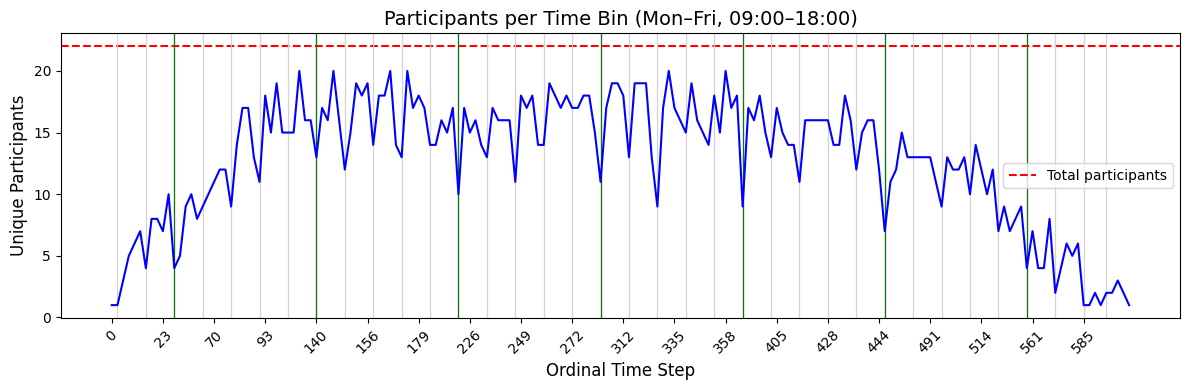

In [23]:
# plot to visualize how many participants are present per time bin (only between 09:00 and 18:00 and on weekdays)
plot_df = positions_links_df[
    (positions_links_df["hour_of_day"] >= 9) &
    (positions_links_df["hour_of_day"] < 18) &
    (positions_links_df["day_of_week"] <= 4)
]
participant_counts = plot_df.groupby("time_bin")["id_participant"].nunique()

x_positions = np.arange(len(participant_counts))
x_labels = participant_counts.index

plt.figure(figsize=(12, 4))
plt.axhline(positions_links_df["id_participant"].nunique(), color='red', linestyle='--', label='Total participants')

# Full set of bins and filtered set
all_bins = positions_links_df["time_bin"].unique()
all_bins = np.sort(all_bins)
included_bins = participant_counts.index
excluded_bins = np.setdiff1d(all_bins, included_bins)

# Map each bin to its weekday/hour (based on bin centers)
bin_hour_map = positions_links_df.groupby("time_bin")["hour_of_day"].first().to_dict()
bin_day_map = positions_links_df.groupby("time_bin")["day_of_week"].first().to_dict()

# Classify excluded bins
weekday_night_bins = []
weekend_bins = []

for b in excluded_bins:
    day = bin_day_map.get(b, None)
    hour = bin_hour_map.get(b, None)
    if day is None or hour is None:
        continue
    if day <= 4:  # Monday to Friday
        if hour < 9 or hour >= 18:
            weekday_night_bins.append(b)
    else:  # Saturday or Sunday
        weekend_bins.append(b)

# Map bin values to ordinal x positions (same as x_labels)
bin_to_x = {b: i for i, b in enumerate(included_bins)}

# Plot vertical lines for removed bins
for b in weekday_night_bins:
    if b in bin_to_x:
        continue  # don't draw if this bin was actually kept
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='lightgray', linestyle='-', linewidth=0.75, alpha =1)

for b in weekend_bins:
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='green', linestyle='-', linewidth=0.75, alpha=0.2)

plt.plot(x_positions, participant_counts.values, color='blue')

plt.xticks(x_positions[::max(len(x_positions)//20,1)], x_labels[::max(len(x_labels)//20,1)], rotation=45)
plt.title("Participants per Time Bin (Mon–Fri, 09:00–18:00)", fontsize=14)
plt.xlabel("Ordinal Time Step", fontsize=12)
plt.ylabel("Unique Participants", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# normalizing edge features

positions_links_df["hour_norm"] = positions_links_df["hour_of_day"] / 23.0     # hours: 0–23
positions_links_df["day_norm"] = positions_links_df["day_of_week"] / 6.0       # days: 0–6

speed_min = positions_links_df["speed"].min()
speed_max = positions_links_df["speed"].max()
positions_links_df["speed_norm"] = (positions_links_df["speed"] - speed_min) / (speed_max - speed_min)

In [25]:
# making the node features

coords = nodes_df[['node_x', 'node_y']].values
coords_min = coords.min(axis=0)
coords_max = coords.max(axis=0)
normalized_coords = (coords - coords_min) / (coords_max - coords_min)  # normalizing coordinates to [0, 1]

binary_features = nodes_df[['Indoors', 'in_Seoul']].values

node_feature_array = np.hstack([normalized_coords, binary_features, urban_features_array])
node_features = torch.tensor(node_feature_array, dtype=torch.float)

In [26]:
def classify_transport_mode(speed):
    speed = speed * (speed_max - speed_min) + speed_min  # denormalizing the speed
    if speed <= 7.5:    # meters per second
        return 0        # Personal mobility (walking, biking, etc)
    else:
        return 1        # Motorized mobility (car, metro, etc.)

In [27]:
# static edge list: all movment links between nodes
static_edges = positions_links_df[["prev_node_id", "node_id"]].dropna()
static_edges = static_edges.astype(int)
static_edge_index = torch.tensor(static_edges.drop_duplicates().values.T, dtype=torch.long)

features = []
edge_indices = []
edge_weights = []
targets = []
edge_features = []

num_nodes = nodes_df["id"].nunique()

min_bin = int(positions_links_df['time_bin'].min())
max_bin = int(positions_links_df['time_bin'].max())
all_time_bins = range(min_bin, max_bin + 1)

for t in all_time_bins:
    df_now = positions_links_df[positions_links_df['time_bin'] == t]
    df_next = positions_links_df[positions_links_df['time_bin'] == t + 1]

    # node features
    visit_df = df_now.groupby("node_id")["id_participant"].nunique()
    visit_counts = visit_df.reindex(range(num_nodes), fill_value=0).values
    visit_tensor = torch.tensor(visit_counts, dtype=torch.float).unsqueeze(1)  # shape: [num_nodes, 1]

    full_node_features = torch.cat([visit_tensor, node_features], dim=1)
    features.append(full_node_features)    

    # edge features, edge index and edge weight
    if not df_now.empty:
        grouped = df_now.groupby(["prev_node_id", "node_id"]).agg({
            "speed_norm": "mean",
            "hour_norm": "mean",
            "day_norm": "mean"
        }).reset_index()

        source = torch.tensor(grouped["prev_node_id"].values, dtype=torch.long)
        destination = torch.tensor(grouped["node_id"].values, dtype=torch.long)
        edge_index = torch.stack([source, destination], dim=0)

        edge_feat = torch.tensor(grouped[["hour_norm", "day_norm", "speed_norm"]].values, dtype=torch.float)
        edge_weight = torch.ones(edge_index.size(1))
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_feat = torch.empty((0, 3), dtype=torch.float)
        edge_weight = torch.empty((0,))
    
    edge_indices.append(edge_index)
    edge_weights.append(edge_weight)
    edge_features.append(edge_feat)


    # node targets
    if df_next.empty:
        node_target = torch.zeros(num_nodes)
    else:
        node_visits = df_next.groupby("node_id")["id_participant"].nunique()
        node_target = torch.tensor(
            node_visits.reindex(range(num_nodes), fill_value=0).values,
            dtype=torch.float
        )
    
    # edge targets
    if df_next.empty:
        edge_target = torch.empty((0,))
        next_edge_index = torch.empty((2, 0), dtype=torch.long)
        transport_target = torch.empty((0,), dtype=torch.long)
        edge_feat_target = torch.empty((0, 3), dtype=torch.float)

    else:
        grouped_next = df_next.groupby(["prev_node_id", "node_id"]).agg({
            "speed_norm": "mean",
            "hour_norm": "mean",
            "day_norm": "mean"
        }).reset_index()

        grouped_next["transport"] = grouped_next["speed_norm"].apply(classify_transport_mode)

        next_source_node = torch.tensor(grouped_next["prev_node_id"].values, dtype=torch.long)
        next_destination_node = torch.tensor(grouped_next["node_id"].values, dtype=torch.long)
        next_edge_index = torch.stack([next_source_node, next_destination_node], dim=0)

        edge_target = torch.tensor(grouped_next["speed_norm"].values, dtype=torch.float)
        transport_target = torch.tensor(grouped_next["transport"].values, dtype=torch.long)

    edge_feat_target = torch.tensor(
        grouped_next[["hour_norm", "day_norm"]].values,
        dtype=torch.float
    )
            
    targets.append((node_target, next_edge_index, edge_target, transport_target, edge_feat_target))

In [28]:
graph_snapshots = []

for t in all_time_bins:
    snapshot = {
        "x": features[t],                         # Node features
        "edge_index": edge_indices[t],            # Edge indices
        "edge_weight": edge_weights[t],           # Edge weights (unused for now)
        "edge_feat": edge_features[t],            # Edge features (speed_norm, hour_norm, day_norm)
        "target_node": targets[t][0],             # Node-level target
        "target_edge_index": targets[t][1],       # Edges to predict speed for
        "target_edge_speed": targets[t][2],       # Edge-level speed prediction
    }
    graph_snapshots.append(snapshot)

In [29]:
t = 15  # Choose any valid time step

snapshot = features[t]             # Node features
edge_index = edge_indices[t]
edge_weight = edge_weights[t]
edge_feat = edge_features[t]

node_target, edge_index_target, edge_target, transport_target, edge_feat_target = targets[t]

print("Time Step:", t)
print("Node features shape:", snapshot.shape)               # [num_nodes, in_channels]
print("Edge index shape:", edge_index.shape)                # [2, num_edges]
print("Edge weight shape:", edge_weight.shape)              # [num_edges]
print("Edge feature shape:", edge_feat.shape)               # [num_edges, edge_feat_dim]
print("Node target shape:", node_target.shape)              # [num_nodes]
print("Target edge index shape:", edge_index_target.shape)  # [2, num_target_edges]
print("Target edge values shape:", edge_target.shape)       # [num_target_edges]

print("\n First 5 node features:\n", snapshot[:5])
print("\n First 5 edge features:\n", edge_feat[:5])
print("\n First 5 node targets:\n", node_target[:5])
print("\n First 5 target edges:\n", edge_index_target[:, :5])
print("\n First 5 target edge values:\n", edge_target[:5])
print("\n First 5 target transport values:\n", transport_target[:5])

Time Step: 15
Node features shape: torch.Size([3774, 9])
Edge index shape: torch.Size([2, 4])
Edge weight shape: torch.Size([4])
Edge feature shape: torch.Size([4, 3])
Node target shape: torch.Size([3774])
Target edge index shape: torch.Size([2, 7])
Target edge values shape: torch.Size([7])

 First 5 node features:
 tensor([[0.0000, 1.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.8536, 0.8536, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.1464, 0.8536, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

 First 5 edge features:
 tensor([[0.9565, 0.5000, 0.0029],
        [1.0000, 0.5000, 0.0029],
        [0.9565, 0.5000, 0.0029],
        [1.0000, 0.5000, 0.0029]])

 First 5 node targets:
 tensor([0., 0., 0., 0., 0.])

 First 5 target edges:
 tensor([[  33,   92, 1188, 12

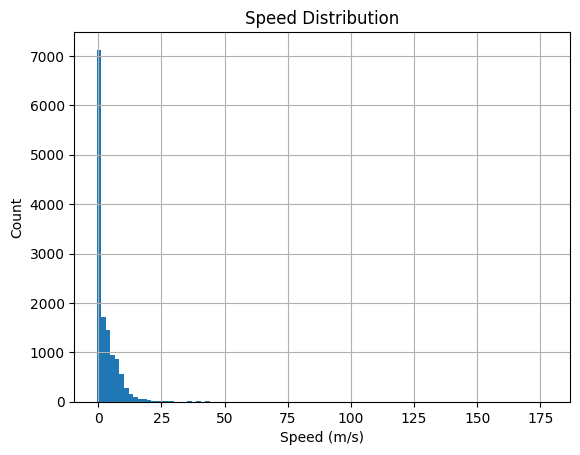

In [30]:
plt.hist(positions_links_df["speed"], bins=100)
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.title("Speed Distribution")
plt.grid()
plt.show()

In [31]:
from torch_geometric.nn import NNConv
from torch.nn import GRUCell, Linear, ReLU, Sequential

class EdgeAwareTemporalEncoder(nn.Module):
    def __init__(self, in_channels, edge_feat_dim, hidden_dim):
        super().__init__()

        # edge-conditioned MLP to produce weights for each edge
        self.edge_nn = Sequential(
            Linear(edge_feat_dim, 32),
            ReLU(),
            Linear(32, in_channels * hidden_dim)
        )

        # NNConv does edge-conditioned message passing
        self.conv = NNConv(
            in_channels=in_channels,
            out_channels=hidden_dim,
            nn=self.edge_nn,
            aggr='mean'
        )

        # GRU maintains temporal state across time steps
        self.gru = GRUCell(hidden_dim, hidden_dim)

    def forward(self, x_seq, edge_index_seq, edge_attr_seq):
        h = None

        for x, edge_index, edge_attr in zip(x_seq, edge_index_seq, edge_attr_seq):
            out = self.conv(x, edge_index, edge_attr)

            if h is None:
                h = out
            else:
                h = self.gru(out, h)

        return h

In [32]:
class MovementLinkPredictor(nn.Module):
    def __init__(self, in_channels, encoder_edge_feat_dim, decoder_edge_feat_dim, hidden_dim):
        super().__init__()

        self.encoder = EdgeAwareTemporalEncoder(
            in_channels=in_channels,
            edge_feat_dim=encoder_edge_feat_dim,  # use 3 for encoder
            hidden_dim=hidden_dim
        )

        # node target prediction
        self.node_decoder = nn.Sequential(
            Linear(hidden_dim, 64),
            ReLU(),
            Linear(64, 1),
        )

        # edge flow decoder
        self.edge_flow_decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim + decoder_edge_feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # transport mode decoder
        self.transport_decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim + decoder_edge_feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward_encoder(self, x_seq, edge_index_seq, edge_attr_seq):
        return self.encoder(x_seq, edge_index_seq, edge_attr_seq)

    def predict_node_counts(self, z):
        return self.node_decoder(z).squeeze(1)

    def predict_edge_flow(self, z, edge_index, edge_feat):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        combined = torch.cat([src, dst, edge_feat], dim=1)
        return self.edge_flow_decoder(combined).squeeze(1)

    def predict_edge_mode(self, z, edge_index, edge_feat):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        combined = torch.cat([src, dst, edge_feat], dim=1)
        return self.transport_decoder(combined)  # shape: [num_edges, num_classes]

In [33]:
# --- Time-Stratified Split ---
def generate_stratified_split(all_bins, train_ratio=0.8, stride=3):
    train_bins = all_bins[::stride]
    test_bins = [b for b in all_bins if b not in train_bins]
    cutoff = int(len(train_bins) * train_ratio)
    return train_bins[:cutoff], test_bins

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Setup ---
window_size = 5
embedding_dim = 64
learning_rate = 0.01
num_epochs = 60

num_nodes = features[0].shape[0]
for ef in edge_features:
    if ef.size(0) > 0:
        edge_feat_dim = ef.shape[1]
        break

encoder_edge_feat_dim = 3   # hour, day, speed (past)
decoder_edge_feat_dim = 2   # hour, day (future only)

all_bins = list(range(window_size, len(features)))
train_bins, test_bins = generate_stratified_split(all_bins)

model = MovementLinkPredictor(
    in_channels=features[0].shape[1],   # node features + visit counts
    encoder_edge_feat_dim=encoder_edge_feat_dim,            # edge features (hour, day, speed)
    decoder_edge_feat_dim=decoder_edge_feat_dim,            # edge features (hour, day)
    hidden_dim=embedding_dim            # hidden dimension for GRU and NNConv
)


optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=0.0005, verbose=True)


c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [35]:
# setting a random seed for reproducibility
# (this will make sure that the results are the same every time the code is run even for random values)

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
import torch.nn.functional as F
import time

start_time_train = time.time()

# --- Training Loop ---
losses = []
for epoch in range(num_epochs):
    model.train()
    loss_sum = 0
    step_count = 0
    epoch_start = time.time()

    for t in train_bins:
        x_seq = features[t - window_size:t]
        ei_seq = edge_indices[t - window_size:t]
        ef_seq = edge_features[t - window_size:t]

        if all(ei.size(1) == 0 for ei in ei_seq):
            continue

        z = model.forward_encoder(x_seq, ei_seq, ef_seq)

        # get current time step targets
        node_target, edge_index_target, edge_target, mode_target, edge_feat_target = targets[t-1]


        if edge_index_target.size(1) == 0:
            continue

        # Forward decoders
        node_pred = model.predict_node_counts(z)
        edge_flow_pred = model.predict_edge_flow(z, edge_index_target, edge_feat_target)
        mode_logits = model.predict_edge_mode(z, edge_index_target, edge_feat_target)

        # Losses
        node_loss = F.mse_loss(node_pred, node_target)
        edge_loss = F.mse_loss(edge_flow_pred, edge_target)
        mode_loss = F.cross_entropy(mode_logits, mode_target)

        total_loss = node_loss + edge_loss + mode_loss  # optionally weight these

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loss_sum += total_loss.item()
        step_count += 1
    
    avg_loss = loss_sum / step_count
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs},\t\tTraining Loss: {avg_loss:.4f},\t\tTime: {time.time() - epoch_start:.2f}s")
    scheduler.step(avg_loss)
    for param_group in optimizer.param_groups:
        print(f"  ⤷ LR: {param_group['lr']:.6f}")

end_time = time.time()
print(f"\nTotal training time: {(end_time - start_time_train):.2f} seconds")



Epoch 1/60,		Training Loss: 0.4191,		Time: 8.83s
  ⤷ LR: 0.010000
Epoch 2/60,		Training Loss: 0.4039,		Time: 9.11s
  ⤷ LR: 0.010000
Epoch 3/60,		Training Loss: 0.3726,		Time: 8.07s
  ⤷ LR: 0.010000
Epoch 4/60,		Training Loss: 0.3616,		Time: 7.93s
  ⤷ LR: 0.010000
Epoch 5/60,		Training Loss: 0.3692,		Time: 8.67s
  ⤷ LR: 0.010000
Epoch 6/60,		Training Loss: 0.3471,		Time: 7.92s
  ⤷ LR: 0.010000
Epoch 7/60,		Training Loss: 0.3416,		Time: 7.69s
  ⤷ LR: 0.010000
Epoch 8/60,		Training Loss: 0.3364,		Time: 7.76s
  ⤷ LR: 0.010000
Epoch 9/60,		Training Loss: 0.3308,		Time: 7.65s
  ⤷ LR: 0.010000
Epoch 10/60,		Training Loss: 0.3206,		Time: 8.25s
  ⤷ LR: 0.010000
Epoch 11/60,		Training Loss: 0.3298,		Time: 7.85s
  ⤷ LR: 0.010000
Epoch 12/60,		Training Loss: 0.3165,		Time: 7.84s
  ⤷ LR: 0.010000
Epoch 13/60,		Training Loss: 0.3245,		Time: 7.86s
  ⤷ LR: 0.010000
Epoch 14/60,		Training Loss: 0.3154,		Time: 7.77s
  ⤷ LR: 0.010000
Epoch 15/60,		Training Loss: 0.3194,		Time: 7.89s
  ⤷ LR: 0.010000
Epoc

In [38]:
np.save("D:/Desktop/MSc Thesis/scripts/losses/loss_11.npy", np.array(losses))

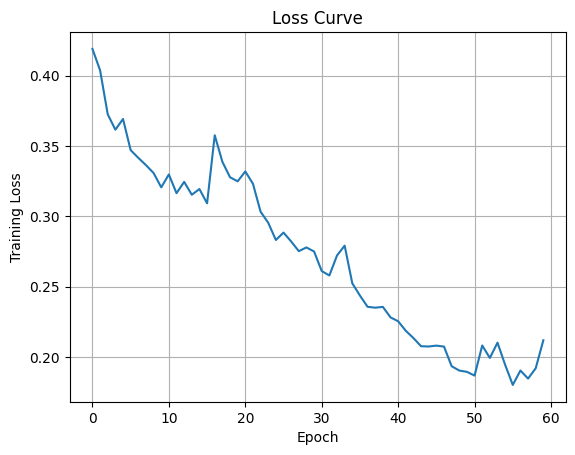

In [39]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
from scipy.stats import pearsonr

def evaluate_multitask(model, features, edge_indices, edge_features, targets, test_bins, threshold=0.5):
    model.eval()
    node_true = []
    node_pred = []
    edge_true = []
    edge_pred = []
    mode_true = []
    mode_pred = []

    with torch.no_grad():
        for t in test_bins:
            x_seq = features[t - window_size:t]         # Node features
            ei_seq = edge_indices[t - window_size:t]    # Edge indices
            ef_seq = edge_features[t - window_size:t]   # Edge features

            if all(ei.size(1) == 0 for ei in ei_seq):
                continue

            z = model.forward_encoder(x_seq, ei_seq, ef_seq)

            node_target, edge_index_target, edge_target, mode_target, edge_feat_target = targets[t-1]

            if edge_index_target.size(1) == 0:
                continue

            # Forward passes
            node_pred_t = model.predict_node_counts(z)
            edge_pred_t = model.predict_edge_flow(z, edge_index_target, edge_feat_target)
            mode_pred_t = model.predict_edge_mode(z, edge_index_target, edge_feat_target)

            # Append for metric computation
            node_true.extend(node_target.detach().cpu().numpy())
            node_pred.extend(node_pred_t.detach().cpu().numpy())
            edge_true.extend(edge_target.detach().cpu().numpy())
            edge_pred.extend(edge_pred_t.detach().cpu().numpy())
            mode_true.extend(mode_target.detach().cpu().numpy())
            predicted_classes = mode_pred_t.argmax(dim=1)
            mode_pred.extend(predicted_classes.detach().cpu().numpy())

    # Convert to numpy arrays for easier handling
    node_true = np.array(node_true)
    node_pred = np.array(node_pred)

    # Node presence binary metrics
    true_binary = (node_true >= 1).astype(int)
    pred_binary = (node_pred >= threshold).astype(int)

    # Compute metrics
    node_mse = mean_squared_error(node_true, node_pred)
    edge_mse = mean_squared_error(edge_true, edge_pred)
    mode_acc = accuracy_score(mode_true, mode_pred)
    precision = precision_score(true_binary, pred_binary, zero_division=0)
    recall = recall_score(true_binary, pred_binary, zero_division=0)
    f1 = f1_score(true_binary, pred_binary, zero_division=0)
    correlation = pearsonr(node_true, node_pred)[0]

    print("\nEvaluation Results:")
    print(f"  ▪ Node Count MSE         : {node_mse:.4f}")
    print(f"  ▪ Edge Flow MSE          : {edge_mse:.4f}")
    print(f"  ▪ Transport Mode Accuracy: {mode_acc:.4f}")
    print(f"  ▪ Node Precision         : {precision:.4f}")
    print(f"  ▪ Node Recall            : {recall:.4f}")
    print(f"  ▪ Node F1 Score          : {f1:.4f}")
    print(f"  ▪ Node Pearson Corr.     : {correlation:.4f}")


In [41]:
evaluate_multitask(model, features, edge_indices, edge_features, targets, test_bins)


Evaluation Results:
  ▪ Node Count MSE         : 0.0061
  ▪ Edge Flow MSE          : 0.0009
  ▪ Transport Mode Accuracy: 0.8541
  ▪ Node Precision         : 0.1934
  ▪ Node Recall            : 0.0191
  ▪ Node F1 Score          : 0.0347
  ▪ Node Pearson Corr.     : 0.1555
